In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

captions  = readTextFile(r"/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(len(captions))
print(captions[0])
first,second  = captions[0].split('\t')
print(first)
print(first.split(".")[0])
print(second)

40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#0
1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
# Dictionary to Map each Image with the list of captions it has

In [ ]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

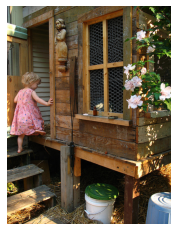

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


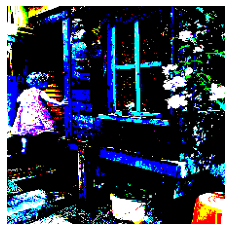

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()


### Data Cleaning


In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
 
clean_text("My name is Raghav. My best friends are Shounak and Nikhil. We play football . My no. is 10 . Nikhil is *8* , Shounak is *7*")
    

'my name is raghav my best friends are shounak and nikhil we play football my no is nikhil is shounak is'

In [ ]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

The processed set of descriptions are written and saved into a new file

In [ ]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)
print(descriptions['1000268201_693b08cb0e']) #we print and have a look at descriptions of any one image 
                                             #There are 5 clean captions of each image"

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


### Vocabulary 

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [ ]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [ ]:
# Filter Words from the Vocab according to certain threshold frequncy

In [ ]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


1845


In [ ]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

1845


In the above code snippets , the aim is to find the total number of words present in the dictionary of words , the total number of unique words present. Further , the dictionary is filtered and only those words are kept in the total_words list which have frequency greater than 10 which is the threshold value set there. This is an important step because we need to quantify all words into numbers to make the model understand them and compute results on top of them.

### Prepare Train/Test Data

In [ ]:
train_file_data = readTextFile("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

Prepare Description for the Training Data
Tweak - Add <startseq> and <endseq> token to our training data

In [ ]:

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

Feature extraction using resnet

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154464, 0.17075905, 0.29276785, ..., 0.05094026, 0.3131964 ,
       0.8600726 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved

In [ ]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 992.717652797699


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [ ]:
# Vocab
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(word_to_idx["dog"])
print(idx_to_word[6])
print(len(idx_to_word))

6
dog
1845


In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Loader (Generator)

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0 

## Word Embeddings 

In [ ]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [ ]:
f.close()

In [ ]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

#### Model Architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

In [ ]:

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//number_pics_per_batch


In [ ]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')


In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.models import load_model, Model

import matplotlib.pyplot as plt
import pickle
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = load_model("/content/drive/MyDrive/data/model_9 (1).h5")


model_temp = ResNet50(weights="imagenet", input_shape=(224,224,3))

model_resnet = Model(model_temp.input, model_temp.layers[-2].output)


102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
with open("/content/drive/MyDrive/data/word_to_idx.pkl", "rb") as w2i:
    word_to_idx = pickle.load(w2i)

with open("/content/drive/MyDrive/data/idx_to_word.pkl", "rb") as i2w:
    idx_to_word = pickle.load(i2w)

In [ ]:
max_len = 35


def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_resnet.predict(img)
    feature_vector = feature_vector.reshape(1, feature_vector.shape[1])
    return feature_vector


In [ ]:
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/haarcascade_frontalface_default.xml')

def facial(path):
  img = cv2.imread(path)
  gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, 1.1, 4)



  for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), )
      roi_color = img[y:y + h, x:x + w] 
      plt.figure()
      plt.imshow(roi_color)

      plt.axis("off")


#plt.imshow(img)
#plt.axis("off")

(-0.5, 719.5, 573.5, -0.5)

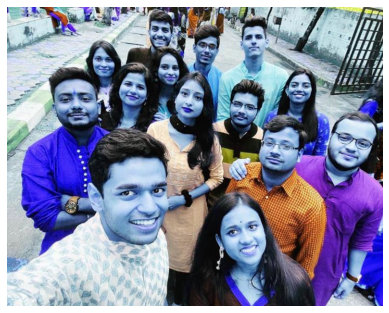

In [ ]:
img = cv2.imread('/content/drive/My Drive/test.jpeg')
plt.imshow(img)
plt.axis("off")

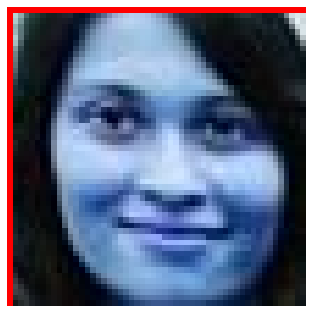

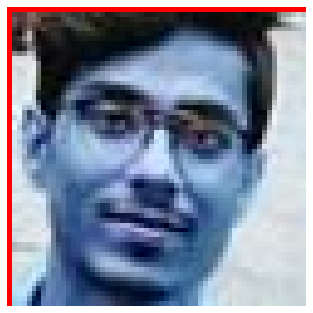

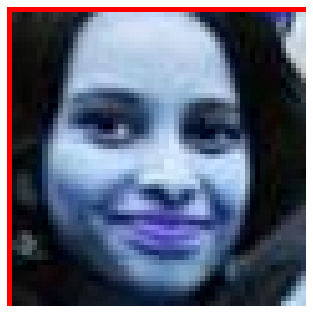

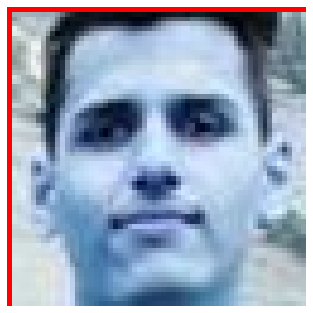

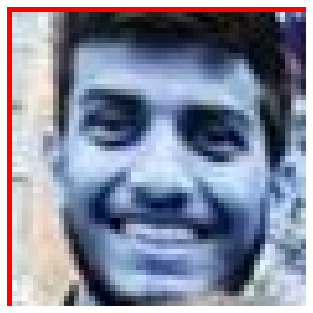

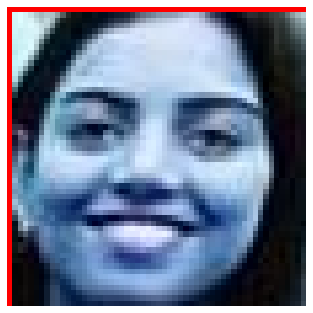

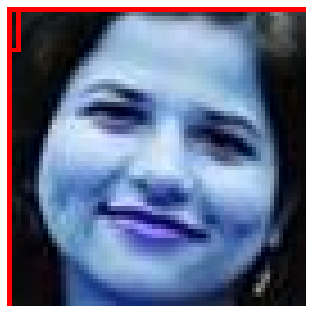

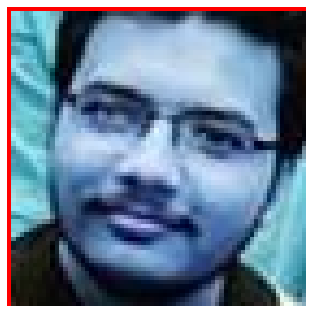

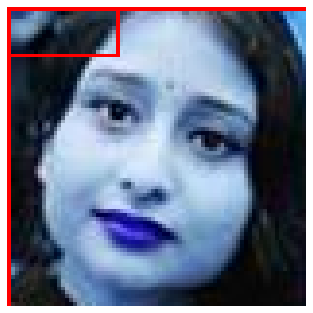

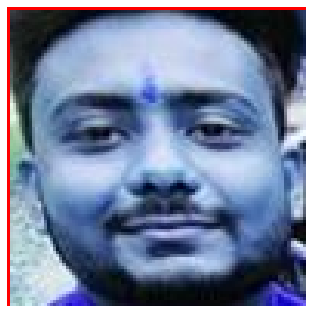

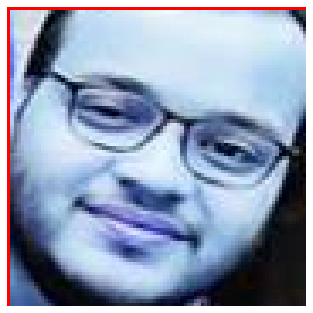

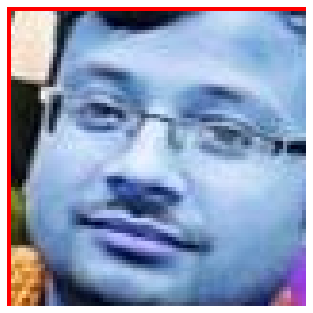

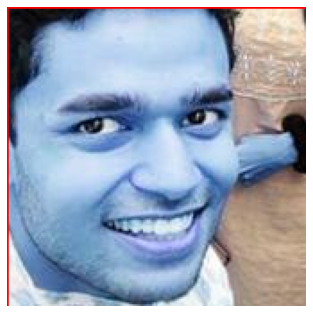

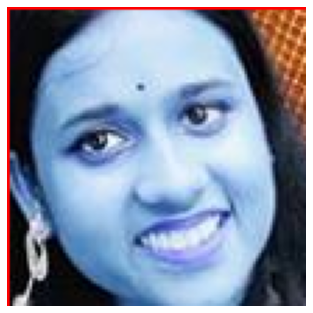

In [ ]:
facial('/content/drive/My Drive/test.jpeg')

(-0.5, 957.5, 1279.5, -0.5)

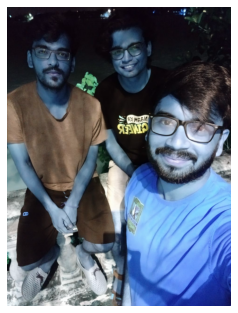

In [ ]:
img = cv2.imread('/content/drive/My Drive/test2.jpeg')
plt.imshow(img)
plt.axis("off")

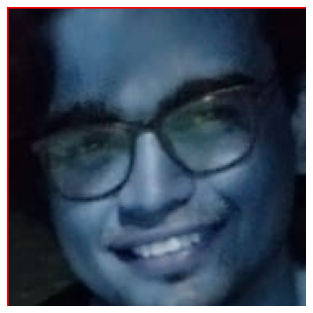

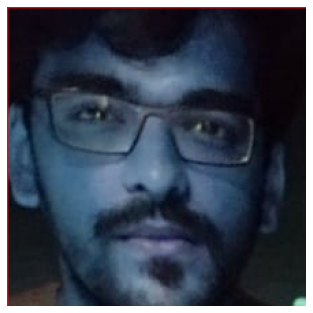

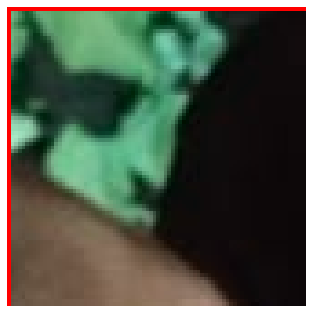

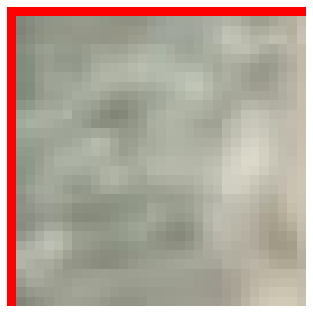

In [ ]:
facial('/content/drive/My Drive/test2.jpeg')

In [ ]:
def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word

        if word =='endseq':
            break


    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption




def caption_this_image(input_img): 

    photo = encode_image(input_img)
    #print(photo)

    caption = predict_caption(photo)
    # keras.backend.clear_session()
    return caption




[[0.06535929 0.16782546 0.32517618 ... 0.05107123 0.32821226 1.004337  ]]
woman in red shirt is sitting on the sidewalk


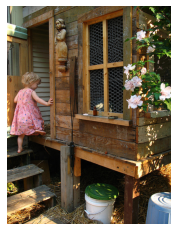

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/"
caption = caption_this_image(IMG_PATH + "1000268201_693b08cb0e.jpg")
print(caption)
import cv2
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
descriptions['1000268201_693b08cb0e']

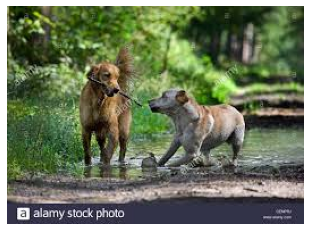

two dogs are running through field


In [ ]:
img = cv2.imread("/content/drive/MyDrive/data/test.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
caption = caption_this_image("/content/drive/MyDrive/data/test.jpg")
print(caption)

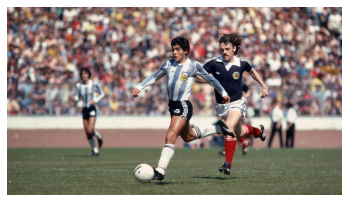

two men in football game


In [ ]:
img = cv2.imread("/content/drive/MyDrive/data/test11.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
caption = caption_this_image("/content/drive/MyDrive/data/test11.jpg")
print(caption)

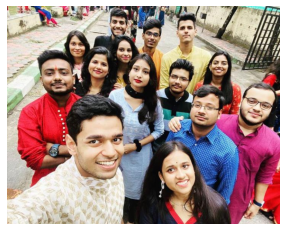

[[0.13959636 1.0573404  0.17532882 ... 0.35590723 0.15602724 0.23349087]]
group of friends pose for picture


In [ ]:
img = cv2.imread("/content/drive/My Drive/test.jpeg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
caption = caption_this_image("/content/drive/My Drive/test.jpeg")
print(caption)

1. Inference Step is left where we calculate the BLUE score corresponding to each image we are feeding as input. Upon calculation of multiple such scores we can draw our inference as to what will be the likely BLUE score for our model.
2. Accumulate a dataset for testing the face crop for images and test it. After that merge it with the existing model to calculate sentiment scores for all faces in an image with multiple faces. Then we can attempt to mix the current captioning model with the sentiment part and generate captions based on that.


In [ ]:
from pickle import load
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' ends '
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
a=encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
print(a)

[[0.06535929 0.16782546 0.32517618 ... 0.05107123 0.32821226 1.004337  ]]


In [ ]:
import os

features = dict()
directory = '/content/drive/MyDrive/Flickr_Data/Images/'
for name in os.listdir(directory):
    ii = directory + '/' + name
    feature = encode_image(ii)
    image_id = name.split('.')[0]
    features[image_id] = feature
    print('>%s' % name)
	

Streaming output truncated to the last 5000 lines.
>3154528397_89112faf4b.jpg
>3165123595_8db9f918bf.jpg
>3132760860_3e743a935d.jpg
>3134387513_ceb75bea0a.jpg
>3150440350_b0f2a9e774.jpg
>3130970054_04a3865c43.jpg
>3145967019_1a83ebf712.jpg
>3123463486_f5b36a3624.jpg
>3139238055_2817a0c7d8.jpg
>3163563871_cef3cf33ea.jpg
>3157847991_463e006a28.jpg
>3158680604_c1f99b3946.jpg
>3154693053_cfcd05c226.jpg
>3124838157_7ef96745b7.jpg
>3126773489_7ae425af17.jpg
>3157039116_d82da4e66b.jpg
>3132619510_7dfc947d25.jpg
>3160531982_37f5636b8a.jpg
>3132006797_04822b5866.jpg
>3147758035_e8a70818cb.jpg
>3143953179_1c08c023a5.jpg
>3164415865_612f9fd8bc.jpg
>3144705706_391d7b77c7.jpg
>3164328039_2c56acf594.jpg
>3143155555_32b6d24f34.jpg
>3145869775_85dfae43bd.jpg
>315436114_6d386b8c36.jpg
>3148647065_2d6cd88cf6.jpg
>3149919755_f9272b10b3.jpg
>3141613533_595723208d.jpg
>3149804151_1cc8d10783.jpg
>3149038044_c7c94688c6.jpg
>3134092148_151154139a.jpg
>3134585858_a8c3493ca5.jpg
>3154709407_9b0778cbeb.jpg
>3158

In [ ]:
with open("features.pkl","wb") as f:
    pickle.dump(features,f)

In [ ]:
print(features)

{'3717531382_e1e05e22c5': array([[0.22227   , 1.0061316 , 0.03817704, ..., 1.7492176 , 0.508408  ,
        1.3019009 ]], dtype=float32), '391723162_3bdeb7ea33': array([[1.1172128 , 0.52300066, 0.8686697 , ..., 0.41991237, 0.04198682,
        0.46703583]], dtype=float32), '3713922357_e0a013fb97': array([[0.35616732, 0.21353304, 0.11655672, ..., 0.06487122, 0.        ,
        0.45944393]], dtype=float32), '3729405438_6e79077ab2': array([[0.19478637, 0.11871988, 0.13529246, ..., 0.22605589, 0.15291156,
        0.36657405]], dtype=float32), '394136487_4fc531b33a': array([[0.16006081, 4.834613  , 1.5794168 , ..., 0.2831407 , 2.6629515 ,
        0.74585396]], dtype=float32), '3726168984_1fa2c8965b': array([[0.9088826 , 0.4771421 , 0.34837326, ..., 0.04678903, 0.49049634,
        0.        ]], dtype=float32), '3725177385_62d5e13634': array([[0.26833734, 0.38017628, 0.47093305, ..., 0.41791174, 0.72293144,
        0.49940023]], dtype=float32), '3728015645_b43a60258b': array([[0.        , 0.20

In [ ]:
filename = '/content/drive/MyDrive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/descriptions_1.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/MyDrive/features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=0
Photos: test=1000


In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog'],['the','fast','brown','fox','jumped','over','the','lazy','dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'from', 'space']
score = sentence_bleu(reference, candidate)
print(score)

0.7860753021519787


In [ ]:
def evaluate(example):
  candi=caption_this_image(example)
  print("Generated Caption : " ,candi)
  print("-----------------------------------------------------------------------------------------------------------------------------")
  candidate=candi.split()
  #print(candidate)
  m=(example.split("/")[-1])
  m=m.split(".")[0]
  #print(m)
  print("Captions for the image in Dataset : ")
  print()
  #print(descriptions[m])
  res=[]
  for i in descriptions[m]:
      print(i)
      r=i.split()
      res.append(r)
  print("-------------------------------------------------------------------------------------------------------------------------------")
  score=sentence_bleu(res,candidate)
  score1=sentence_bleu(res, candidate, weights=(1, 0, 0, 0))
  score2=sentence_bleu(res, candidate, weights=(0, 1, 0, 0))
  score3=sentence_bleu(res, candidate, weights=(0, 0, 1, 0))
  score4=sentence_bleu(res, candidate, weights=(0, 0, 0, 1))
  print("Sentence BLUE scores :")
  print("1-gram BLUE score : ",score1)
  print("2-gram BLUE score : ",score2)
  print("3-gram BLUE score : ",score3)
  print("4-gram BLUE score : ",score4)
  print("--------------------------------------------------------------------------------------------------------------------------------")
  return score




def generate(inpt):
  IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/"
  import cv2
  img = cv2.imread(IMG_PATH+inpt)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/"
  caption = evaluate(IMG_PATH + inpt)
  #print("BLUE Score Values:" , caption)
  #descriptions['1000268201_693b08cb0e']





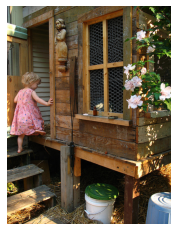

Generated Caption :  woman in red shirt is sitting on the sidewalk
-----------------------------------------------------------------------------------------------------------------------------
Captions for the image in Dataset : 

child in pink dress is climbing up set of stairs in an entry way
girl going into wooden building
little girl climbing into wooden playhouse
little girl climbing the stairs to her playhouse
little girl in pink dress going into wooden cabin
-------------------------------------------------------------------------------------------------------------------------------
Sentence BLUE scores :
1-gram BLUE score :  0.3333333333333333
2-gram BLUE score :  1.0
3-gram BLUE score :  1.0
4-gram BLUE score :  1.0
--------------------------------------------------------------------------------------------------------------------------------


In [ ]:
generate("1000268201_693b08cb0e.jpg")


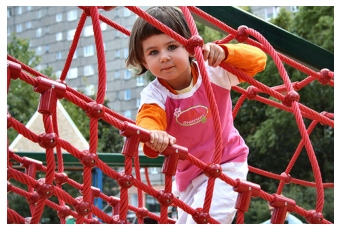

Generated Caption :  boy in blue shirt and blue shorts is playing with colorful toy
-----------------------------------------------------------------------------------------------------------------------------
Captions for the image in Dataset : 

child playing on rope net
little girl climbing on red roping
little girl in pink climbs rope bridge at the park
small child grips onto the red ropes at the playground
the small child climbs on red ropes on playground
-------------------------------------------------------------------------------------------------------------------------------
Sentence BLUE scores :
1-gram BLUE score :  0.16666666666666669
2-gram BLUE score :  1.0
3-gram BLUE score :  1.0
4-gram BLUE score :  1.0
--------------------------------------------------------------------------------------------------------------------------------


In [ ]:
generate("1007320043_627395c3d8.jpg")

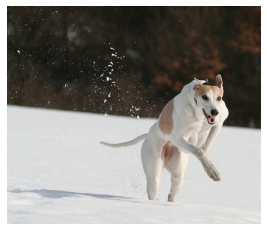

Generated Caption :  dog runs through the snow
-----------------------------------------------------------------------------------------------------------------------------
Captions for the image in Dataset : 

brown and white dog is running through the snow
dog is running in the snow
dog running through snow
white and brown dog is running through snow covered field
the white and brown dog is running over the surface of the snow
-------------------------------------------------------------------------------------------------------------------------------
Sentence BLUE scores :
1-gram BLUE score :  0.8
2-gram BLUE score :  0.5
3-gram BLUE score :  0.3333333333333333
4-gram BLUE score :  1.0
--------------------------------------------------------------------------------------------------------------------------------


In [ ]:
generate("101654506_8eb26cfb60.jpg")

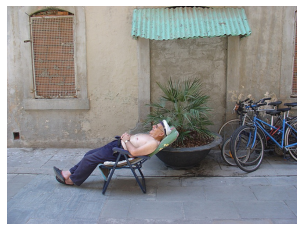

Generated Caption :  man in blue shirt is sitting on bench
-----------------------------------------------------------------------------------------------------------------------------
Captions for the image in Dataset : 

half naked man is sleeping on his chair outdoors
an older man sits back and relaxes on patio outside an adobe building where many bicycles are propped
shirtless man in white cap relaxes in deck chair close to three parked bicycles
man relaxing in folding chair on the street
topless old man wearing slippers navy blue pants and white hat while reclining in chair outside
-------------------------------------------------------------------------------------------------------------------------------
Sentence BLUE scores :
1-gram BLUE score :  0.625
2-gram BLUE score :  0.14285714285714285
3-gram BLUE score :  1.0
4-gram BLUE score :  1.0
--------------------------------------------------------------------------------------------------------------------------------


In [ ]:
generate("1124448967_2221af8dc5.jpg")

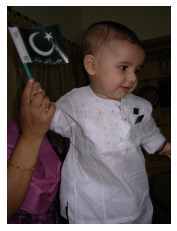

Generated Caption :  boy with his arms around his head
-----------------------------------------------------------------------------------------------------------------------------
Captions for the image in Dataset : 

baby in white garment holds flag with crescent moon and star
baby is holding small black flag with moon and star on it
baby wearing white gown waves muslim flag
little toddler dressed in white is smiling while lady helps him wave flag
baby in white outfit holding black and white flag
-------------------------------------------------------------------------------------------------------------------------------
Sentence BLUE scores :
1-gram BLUE score :  0.14285714285714285
2-gram BLUE score :  1.0
3-gram BLUE score :  1.0
4-gram BLUE score :  1.0
--------------------------------------------------------------------------------------------------------------------------------


In [ ]:
generate("1122944218_8eb3607403.jpg")

In [ ]:
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog'],['the','fast','brown','fox','jumped','over','the','lazy','dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'from', 'space']
from nltk.translate.bleu_score import sentence_bleu
print(sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print(sentence_bleu(reference, candidate, weights=(1,0 , 0, 0)))
print(sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print(sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

0.8
0.8181818181818182
0.7777777777777778
0.75
